In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
import cmocean
from pyqg_generative.tools.plot_helpers import *
from pyqg_generative.tools.comparison_tools import dataset_smart_read, dataset_light_read, distrib_score, spectral_score
from pyqg_generative.tools.operators import ave_lev
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev, coord
from pyqg_generative.tools.parameters import EDDY_PARAMS
from pyqg_generative.tools.spectral_tools import calc_ispec, coord, spectrum
from pyqg_generative.tools.computational_tools import PDF_histogram
from pyqg_generative.tools.simulate import run_simulation
%load_ext autoreload
%autoreload 3

import hvplot.xarray
import holoviews as hv
hvplot.output(widget_location='bottom')

import warnings
warnings.filterwarnings("ignore")

# Idealized ocean model

In [14]:
ds = {}
exps = ['48', '64', '128']#, '64', '96', '128', '256', '512']
for res in exps:
    print(res)
    ds[res] = dataset_light_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_{res}/[0-9].nc', delta=0.25)    

48
64
128


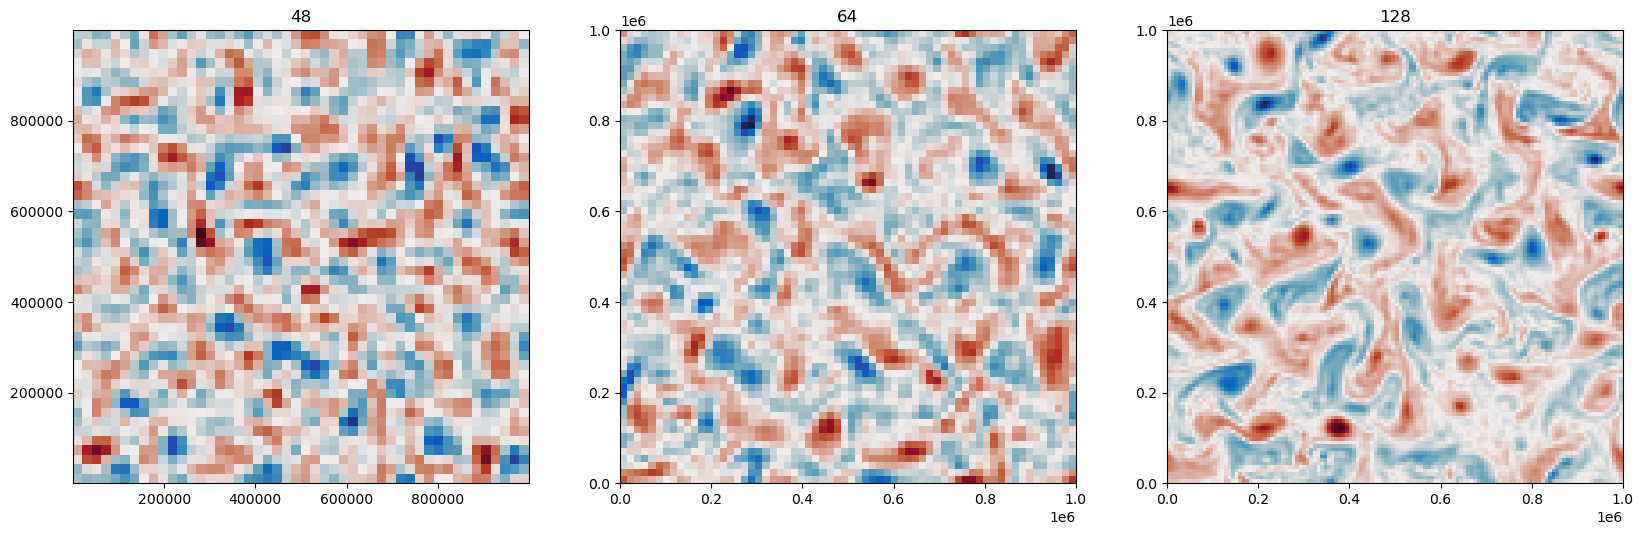

In [15]:
plt.figure(figsize=(20,20))
for col, res in enumerate(exps):
    plt.subplot(3,3,col+1)
    ds[res].q.isel(time=-1,run=0,lev=0).plot.imshow(cmap=cmocean.cm.balance, add_colorbar=False, interpolation='none')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(res)
plt.savefig('Snapshot_resolutions.pdf')

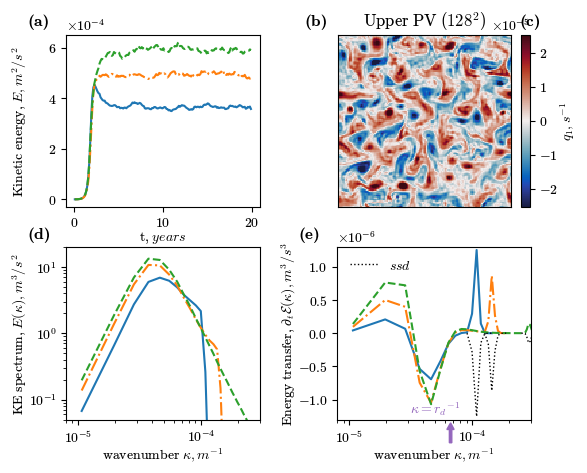

In [19]:
default_rcParams({})
matplotlib.rcParams.update({
    'figure.subplot.wspace': 0.4, 
    'figure.subplot.hspace': 0.23, 
    'figure.figsize': (6, 5),
    'axes.titlelocation' : 'center'})
ls = {'512': '-', '256': '-', '128': '--', '96': ':', '64': '-.', '48': '-', '48_recompute': '-.'}

fig = plt.figure()

plt.subplot(2,2,1)
for res in exps:
    ds[res].KE_time.plot(ls=ls[res], label=f'${res}^2$')
plt.ylabel(r'Kinetic energy, $E, m^2/s^2$')
plt.xlabel('t, $years$')
#plt.title('Kinetic energy')
#plt.legend(ncol=2, frameon=False)

plt.subplot(2,2,2)
q = ds['128'].q.isel(time=-1,run=0,lev=0)
imshow(q, cbar_label='$q_1, s^{-1}$')
plt.title('Upper PV ($128^2$)')

plt.subplot(2,2,3)
for res in exps:
    (0.5*ds[res].KEspecr_mean).plot(ls=ls[res])
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-2, 2e+1])
plt.xlim([8e-6,3e-4])
plt.ylabel('KE spectrum, $E(\kappa), m^3/s^2$')
plt.xlabel(r'wavenumber $\kappa, m^{-1}$')
#plt.title('KE spectrum')

plt.subplot(2,2,4)
for res in exps:
    ds[res].Efluxr.plot(ls=ls[res])
flag = True
for res in exps:
    idx = 0
    for i in range(len(ds[res].kr)):
        if ds[res].Dissspecr[i] < 0:
            idx = i-1
            break
    ds[res].Dissspecr[idx:].plot(color='k', ls=':', lw=1, label='$ssd$' if flag else None); flag=False
plt.xscale('log')
plt.xlim([8e-6,3e-4])
plt.ylim([-1.3e-6, 1.3e-6])
plt.ylabel(r'Energy transfer, $\partial_t \mathcal{E}(\kappa), m^3/s^3$')
plt.xlabel(r'wavenumber $\kappa, m^{-1}$')
#plt.title('Energy transfer')
#plt.legend(ncol=1, bbox_to_anchor=(1.47,1), loc='upper right')
plt.legend(frameon=False)
plt.arrow(1/15000, -1.65e-6, 0, +0.2e-6, width=3e-6, head_length=1e-7, clip_on=False, color='tab:purple')
plt.text(5e-5, -1.2e-6, '$\kappa={r_d}^{-1}$', color='tab:purple', horizontalalignment='center')

fig.align_ylabels()
set_letters()
plt.show()
#plt.savefig('paper_figures_1/fig1_2_2.pdf')

# Determining enstrophy flux

In [201]:
ds = {}
ds['64_op1'] = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/*.nc', concat_dim='run', combine='nested', decode_times=False)
ds['64_op2'] = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-64/*.nc', concat_dim='run', combine='nested', decode_times=False)

ds['96_op1'] = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-96/*.nc', concat_dim='run', combine='nested', decode_times=False)
ds['96_op2'] = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-96/*.nc', concat_dim='run', combine='nested', decode_times=False)


In [356]:
dss = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_512/[0-9].nc', concat_dim='run', combine='nested', decode_times=False)

In [357]:
vrms = velocity_rms(dss).compute()

In [202]:
def enstrophy_flux(ds):
    return -(ds.q_forcing_advection * ds.q).mean(['x','y', 'run'])

In [203]:
def velocity_rms(ds):
    return np.sqrt((ds.u**2 + ds.v**2).mean(['x', 'y', 'run']))

<xarray.DataArray ()>
array(0.07452768, dtype=float32)
Coordinates:
    lev      int64 1

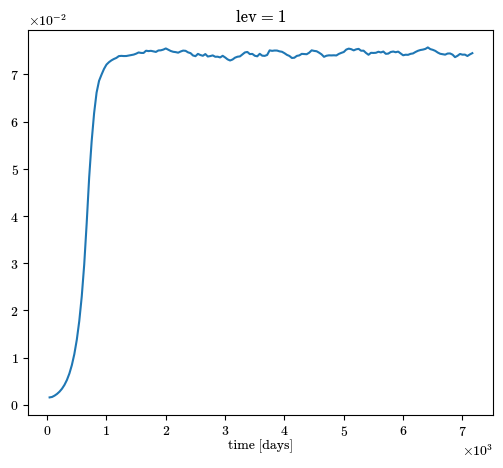

In [361]:
vrms.isel(lev=0).plot()
vrms.isel(lev=0).sel(time=slice(3600,None)).mean()

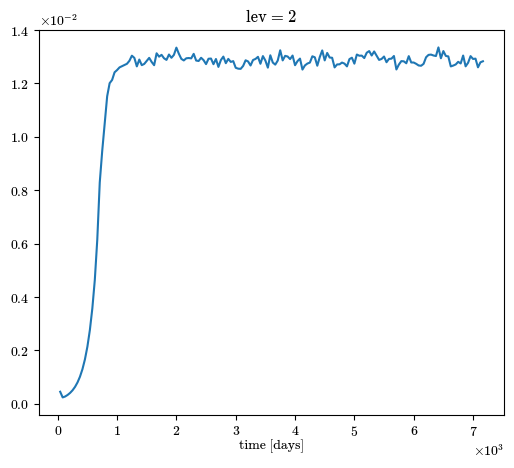

In [359]:
vrms.isel(lev=1).plot()

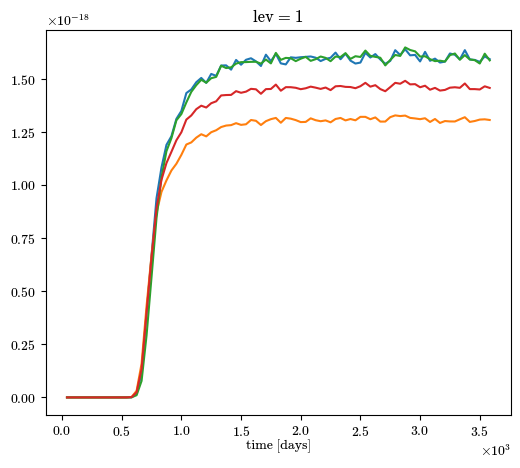

In [206]:
enstrophy_flux(ds['64_op1']).isel(lev=0).plot(label='64 op1')
enstrophy_flux(ds['64_op2']).isel(lev=0).plot(label='64 op2')

enstrophy_flux(ds['96_op1']).isel(lev=0).plot(label='96 op1')
enstrophy_flux(ds['96_op2']).isel(lev=0).plot(label='96 op2')

In [362]:
eta = enstrophy_flux(ds['64_op1']).isel(lev=0).compute()

In [367]:
eta.sel(time=slice(1800,None)).mean()

<xarray.DataArray ()>
array(1.5973519e-18, dtype=float32)
Coordinates:
    lev      int32 1

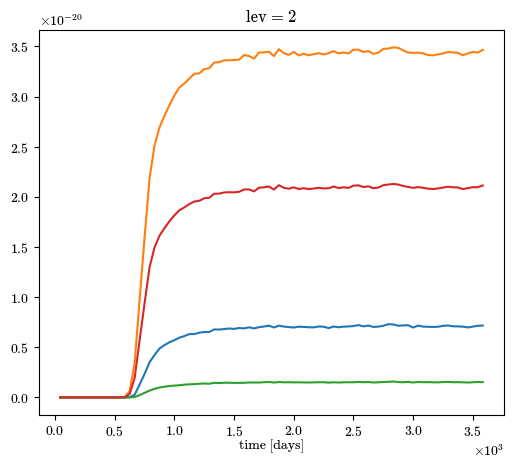

In [207]:
enstrophy_flux(ds['64_op1']).isel(lev=1).plot(label='64 op1')
enstrophy_flux(ds['64_op2']).isel(lev=1).plot(label='64 op2')

enstrophy_flux(ds['96_op1']).isel(lev=1).plot(label='96 op1')
enstrophy_flux(ds['96_op2']).isel(lev=1).plot(label='96 op2')

## All scales of motion
Domain length:
$$
L = 10^{6} m
$$

Velocity scale in upper layer:
$$
v_{rms}=0.07452768 m/s \approx 0.075 m/s
$$

Potential enstrophy flux over enstrophy cascade in upper layer:
$$
\eta = 1.5973519 \cdot 10^{-18} s^{-3} \approx 1.6 \cdot 10^{-18} s^{-3}
$$

## Kolmogorov scale
Dissipation (Kolmogorov) scale as a function of enstrophy flux and viscosity:
$$
l_{K} = \eta^{n} (\nu)^{k} = [1/T^3]^{n} [L^2/T]^{k} = L \rightarrow k=1/2, n=-1/2
$$
and
$$
l_{K} = {\nu}^{1/2} \eta^{-1/6}
$$

Typical choice: Kolmogorov lengthscale is equal to the grid step: 
$$
l_{K} \approx \Delta x
$$
See for explanation: https://journals.aps.org/prfluids/pdf/10.1103/PhysRevFluids.5.054606 (TABLE 1) also (Guan2022) https://www.sciencedirect.com/science/article/pii/S0021999122001528

Consequently, 
$$
\nu = \eta^{1/3} (\Delta x)^2
$$

Conversely, in diagnostic sense. The ratio of Kolmogorov scale to the grid scale:
$$
\frac{l_{K}}{\Delta x} = \frac{{\nu}^{1/2} \eta^{-1/6}}{\Delta x}
$$

## Reynolds number
In many works the length scale is chosen as
$$\tilde{L} = \frac{L}{2 \pi}$$
velocity scale as $v_{rms}$, and then the Reynolds number:
$$
Re = \frac{u_{rms} \tilde{L}}{\nu}
$$
Typical values for $Re$ is 64000 on a grid $1024^2$ (see Frezat, Guan, Kaushik). According to quadratic law we will scale Reynolds number for coarser grids.

In [376]:
for n in [48, 64, 96, 128, 256, 512, 1024, 2048]:
    L = 1e+6
    eta = 1.6e-18
    vrms = 0.075
    dx = L / float(n)
    
    L_tilde = L / (2 * np.pi)
    
    Re = 64000 * (n/1024)**2
    
    nu = vrms * L_tilde / Re
    
    Kolmogorov = nu**(0.5) * eta**(-1/6.)
    
    Re_compute = vrms * L_tilde / nu
    print(f'Resolution: {n}; viscosity (m^2/s): {nu}; Re: {Re,Re_compute}, Kolmogorov/dx: {Kolmogorov/dx}')

Resolution: 48; viscosity (m^2/s): 84.88263631567752; Re: (140.625, 140.625), Kolmogorov/dx: 0.40891276683620686
Resolution: 64; viscosity (m^2/s): 47.7464829275686; Re: (250.0, 250.0), Kolmogorov/dx: 0.4089127668362069
Resolution: 96; viscosity (m^2/s): 21.22065907891938; Re: (562.5, 562.5), Kolmogorov/dx: 0.40891276683620686
Resolution: 128; viscosity (m^2/s): 11.93662073189215; Re: (1000.0, 1000.0), Kolmogorov/dx: 0.4089127668362069
Resolution: 256; viscosity (m^2/s): 2.9841551829730375; Re: (4000.0, 4000.0), Kolmogorov/dx: 0.4089127668362069
Resolution: 512; viscosity (m^2/s): 0.7460387957432594; Re: (16000.0, 16000.0), Kolmogorov/dx: 0.4089127668362069
Resolution: 1024; viscosity (m^2/s): 0.18650969893581484; Re: (64000.0, 64000.0), Kolmogorov/dx: 0.4089127668362069
Resolution: 2048; viscosity (m^2/s): 0.04662742473395371; Re: (256000.0, 256000.0), Kolmogorov/dx: 0.4089127668362069


# Pyqg with molecular viscosity

In [212]:
from pyqg import QParameterization

In [377]:
class Laplace(QParameterization):
    def __init__(self, nu=0., PV=True):
        self.nu = nu
        self.PV = PV

    def __call__(self, m):
        lap = m.ik**2 + m.il**2
        if self.PV:
            qh = m.qh
        else:
            qh = lap * m.ph
        
        dq = self.nu * m.ifft(lap * qh)
        return dq

In [378]:
pyqg_exp = {'nx': 64, 'dt': 14400, 'tmax': 311040000, 'tavestart': 155520000}
pyqg_lap = {'nx': 64, 'dt': 14400, 'tmax': 311040000, 'tavestart': 155520000, 'parameterization': Laplace(50,False), 'filterfac': 1e+20}
pyqg_invisc = {'nx': 64, 'dt': 14400, 'tmax': 311040000, 'tavestart': 155520000, 'filterfac': 1e+20}

In [307]:
invisc = run_simulation(pyqg_invisc)

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 7.50e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 3.65e-06, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 2.47e-05, CFL: 0.034
INFO: Step: 4000, Time years:  1.9, KE: 1.91e-04, CFL: 0.096
INFO: Step: 5000, Time years:  2.3, KE: 5.35e-04, CFL: 0.212
INFO: Step: 6000, Time years:  2.8, KE: 6.67e-04, CFL: 0.221
INFO: Step: 7000, Time years:  3.2, KE: 6.72e-04, CFL: 0.216
INFO: Step: 8000, Time years:  3.7, KE: 6.27e-04, CFL: 0.187
INFO: Step: 9000, Time years:  4.2, KE: 6.10e-04, CFL: 0.228
INFO: Step: 10000, Time years:  4.6, KE: 6.10e-04, CFL: 0.216
INFO: Step: 11000, Time years:  5.1, KE: 6.20e-04, CFL: 0.181
INFO: Step: 12000, Time years:  5.6, KE: 6.37e-04, CFL: 0.189
INFO: Step: 13000, Time years:  6.0, KE: 6.56e-04, CFL: 0.193
INFO: Step: 14000, Time years:  6.5, KE: 6.75e-04, CFL: 0.187
INFO: Step: 15000, Time years:  6.9, KE: 6.95e-04, CFL: 0.224
INFO: Step: 16000, Time years:  7.4, KE: 7.15e-04, CF

Function 'run_simulation' executed in 21.8433s


In [379]:
lap_50_rel = run_simulation(pyqg_lap)

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 2.65e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 8.50e-07, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 3.14e-06, CFL: 0.023
INFO: Step: 4000, Time years:  1.9, KE: 1.19e-05, CFL: 0.023
INFO: Step: 5000, Time years:  2.3, KE: 4.58e-05, CFL: 0.029
INFO: Step: 6000, Time years:  2.8, KE: 1.76e-04, CFL: 0.055
INFO: Step: 7000, Time years:  3.2, KE: 6.91e-04, CFL: 0.118
INFO: Step: 8000, Time years:  3.7, KE: 3.70e-04, CFL: 0.146
INFO: Step: 9000, Time years:  4.2, KE: 2.27e-04, CFL: 0.131
INFO: Step: 10000, Time years:  4.6, KE: 1.71e-04, CFL: 0.108
INFO: Step: 11000, Time years:  5.1, KE: 1.37e-04, CFL: 0.107
INFO: Step: 12000, Time years:  5.6, KE: 1.54e-04, CFL: 0.103
INFO: Step: 13000, Time years:  6.0, KE: 1.57e-04, CFL: 0.115
INFO: Step: 14000, Time years:  6.5, KE: 1.75e-04, CFL: 0.134
INFO: Step: 15000, Time years:  6.9, KE: 1.63e-04, CFL: 0.127
INFO: Step: 16000, Time years:  7.4, KE: 1.91e-04, CF

Function 'run_simulation' executed in 25.3045s


In [309]:
exp = run_simulation(pyqg_exp)

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 1.26e-06, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 7.87e-06, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 5.99e-05, CFL: 0.038
INFO: Step: 4000, Time years:  1.9, KE: 4.56e-04, CFL: 0.137
INFO: Step: 5000, Time years:  2.3, KE: 4.78e-04, CFL: 0.212
INFO: Step: 6000, Time years:  2.8, KE: 5.23e-04, CFL: 0.222
INFO: Step: 7000, Time years:  3.2, KE: 4.92e-04, CFL: 0.163
INFO: Step: 8000, Time years:  3.7, KE: 4.77e-04, CFL: 0.206
INFO: Step: 9000, Time years:  4.2, KE: 4.49e-04, CFL: 0.160
INFO: Step: 10000, Time years:  4.6, KE: 4.79e-04, CFL: 0.206
INFO: Step: 11000, Time years:  5.1, KE: 4.84e-04, CFL: 0.177
INFO: Step: 12000, Time years:  5.6, KE: 4.59e-04, CFL: 0.156
INFO: Step: 13000, Time years:  6.0, KE: 4.88e-04, CFL: 0.177
INFO: Step: 14000, Time years:  6.5, KE: 5.15e-04, CFL: 0.194
INFO: Step: 15000, Time years:  6.9, KE: 4.91e-04, CFL: 0.166
INFO: Step: 16000, Time years:  7.4, KE: 5.26e-04, CF

Function 'run_simulation' executed in 22.0348s


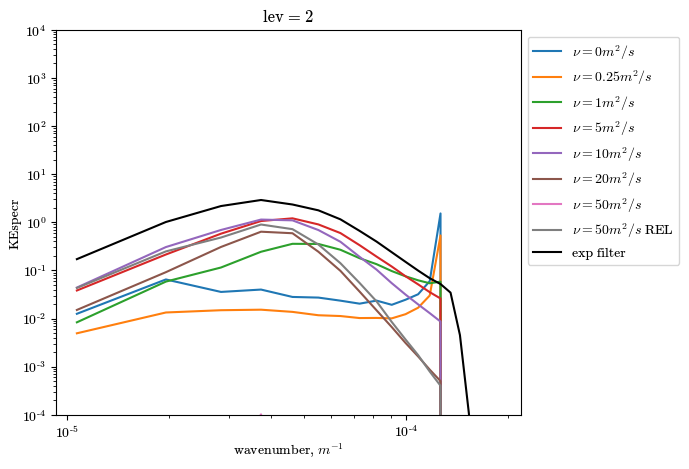

In [389]:
lev=1
dataset_light_read(invisc).KEspecr.isel(lev=lev).plot(label='$\\nu=0 m^2/s$')
dataset_light_read(lap_025).KEspecr.isel(lev=lev).plot(label='$\\nu=0.25 m^2/s$')
dataset_light_read(lap_1).KEspecr.isel(lev=lev).plot(label='$\\nu=1 m^2/s$')
dataset_light_read(lap_5).KEspecr.isel(lev=lev).plot(label='$\\nu=5 m^2/s$')
dataset_light_read(lap).KEspecr.isel(lev=lev).plot(label='$\\nu=10 m^2/s$')
dataset_light_read(lap_20).KEspecr.isel(lev=lev).plot(label='$\\nu=20 m^2/s$')
dataset_light_read(lap_50).KEspecr.isel(lev=lev).plot(label='$\\nu=50 m^2/s$')
dataset_light_read(lap_50_rel).KEspecr.isel(lev=lev).plot(label='$\\nu=50 m^2/s$ REL')
dataset_light_read(exp).KEspecr.isel(lev=lev).plot(color='k', label='exp filter')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-4,1e+4])
plt.legend(bbox_to_anchor=(1,1))

# Conservation laws for advection operator

In [405]:
filtr = np.array(pyqg.QGModel(filterfac=1e+20).filtr)

INFO:  Logger initialized


In [406]:
np.unique(filtr)

array([0., 1.])

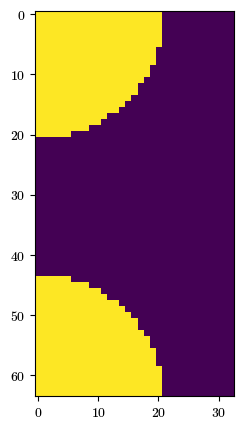

In [407]:
plt.imshow(filtr)

# advect function from operators module

In [87]:
import pyqg_generative.tools.operators as op 

In [752]:
m = pyqg.QGModel()
filtr = np.array(pyqg.QGModel(filterfac=1e+20).filtr)

INFO:  Logger initialized
INFO:  Logger initialized


In [789]:
dss = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/0.nc', decode_times=False)
lap = (m.ik)**2 + (m.il)**2
q = dss.q.isel(time=-1).values.astype('float64')
m.q = q#m.ifft(lap * m.fft(q))
m._invert()
np.linalg.norm(q-m.q)

0.0

In [1]:
import xrft
sp = lambda x: xrft.isotropic_power_spectrum(xr.DataArray(x)).plot(xscale='log', yscale='log', marker='o')
csp = lambda x,y: np.real(xrft.isotropic_cross_spectrum(xr.DataArray(x), xr.DataArray(y))).plot(xscale='log', marker='o')

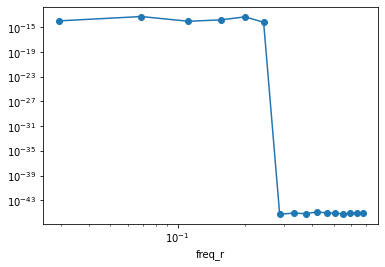

In [869]:
sp(m.q[0])

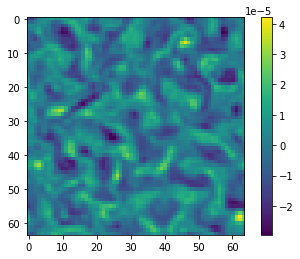

In [792]:
plt.imshow(m.q[0]);plt.colorbar()

### Without dealiasing

In [793]:
def test_PV(dqdt):
    return dqdt.mean(axis=(-2,-1)) / dqdt.std(axis=(-2,-1))

def test_Ens(dqdt,q):
    '''
    Returns timescale on which enstrophy will be changed
    in days
    '''
    return (q*dqdt).mean(axis=(-2,-1)) / (q.std(axis=(-2,-1)) * dqdt.std(axis=(-2,-1)))

def test_En(dqdt,psi):
    return (psi*dqdt).mean(axis=(-2,-1)) / (psi.std(axis=(-2,-1)) * dqdt.std(axis=(-2,-1)))

In [794]:
q = m.q
psi = m.ifft(m.ph)
u = m.u
v = m.v
dqdt = op.advect(q,u,v)
dqdt_two_thirds = op.advect(q,u,v,dealias='2/3-rule')
dqdt_three_second= op.advect(q,u,v,dealias='3/2-rule')

In [795]:
print(test_PV(dqdt))
print(test_PV(dqdt_two_thirds))
print(test_PV(dqdt_three_second))

[-4.99507412e-19 -2.92766947e-18]
[ 7.34534196e-18 -3.07244017e-18]
[-5.57715856e-19  2.34988861e-18]


In [796]:
print(test_Ens(dqdt,q))
print(test_Ens(dqdt_two_thirds,q))
print(test_Ens(dqdt_three_second,q))

[-2.47353362e-05  1.14621001e-05]
[-2.74793201e-17  2.37174341e-18]
[1.61019131e-17 8.61638615e-18]


In [797]:
print(test_En(dqdt,psi))
print(test_En(dqdt_two_thirds,psi))
print(test_En(dqdt_three_second,psi))

[0.00000000e+00 6.30075276e-18]
[ 1.91668452e-17 -1.10205325e-17]
[-2.53095115e-17 -7.02401086e-18]


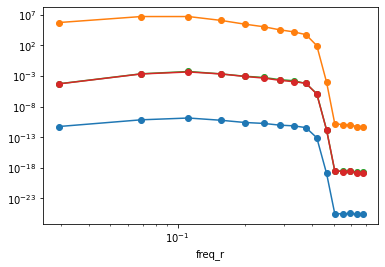

In [798]:
sp(q[0])
sp(psi[0])
sp(u[0])
sp(v[0])

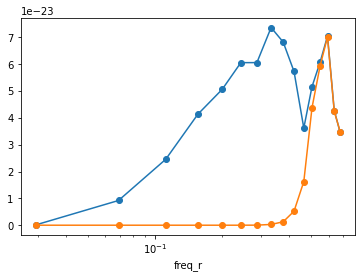

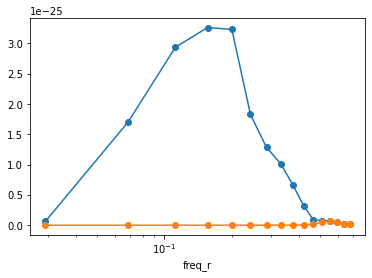

In [805]:
plt.figure()
sp(dqdt[0])
#sp(dqdt_two_thirds[0])
sp(dqdt_three_second[0]-dqdt[0])
plt.yscale('linear')

plt.figure()
sp(dqdt[1])
#sp(dqdt_two_thirds[1])
sp(dqdt_three_second[1]-dqdt[1])
#plt.ylim([1e-28,1e-22])
plt.yscale('linear')

# FFT regridding on test functions

In [812]:
[X,Y] = np.meshgrid(np.linspace(0,2*np.pi,17)[:-1], np.linspace(0,2*np.pi,17)[:-1])
[Xt,Yt] = np.meshgrid(np.linspace(0,2*np.pi,25)[:-1], np.linspace(0,2*np.pi,25)[:-1])
[Xtt,Ytt] = np.meshgrid(np.linspace(0,2*np.pi,9)[:-1], np.linspace(0,2*np.pi,9)[:-1])
Z = np.cos(1*X) * np.sin(1*Y)
Zt = np.cos(1*Xt) * np.sin(1*Yt)
Ztt = np.cos(1*Xtt) * np.sin(1*Ytt)

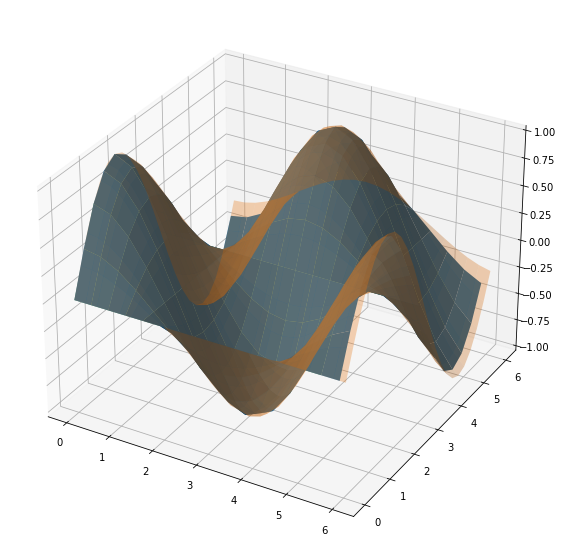

In [813]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
ax.plot_surface(Xt, Yt, Zt, alpha=0.3)
ax.plot_surface(Xtt, Ytt, Ztt, alpha=0.5)

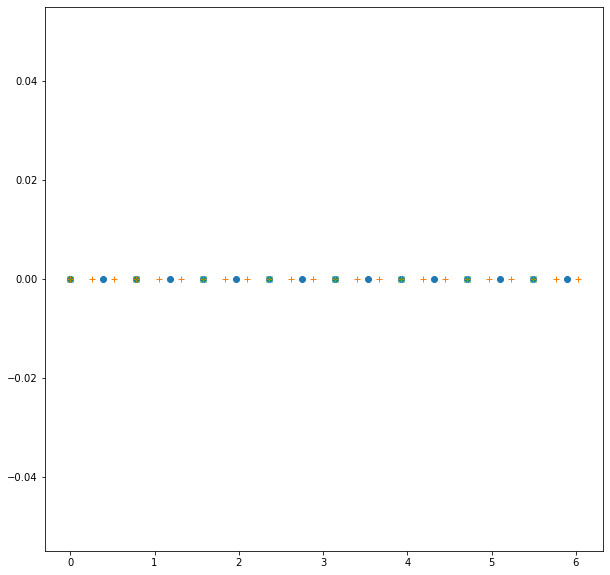

In [814]:
plt.figure(figsize=(10,10))
plt.plot(X[0],Z[0],'o')
plt.plot(Xt[0],Zt[0],'+')
plt.plot(Xtt[0],Ztt[0],'x')

In [815]:
x = np.random.randn(4,4)
np.linalg.norm(x-op.fft_interpolate(x,4,4))

2.719791912321612

In [818]:
np.linalg.norm(Zt-op.fft_interpolate(Z,16,24))

7.807311853781127e-15

In [819]:
np.linalg.norm(Ztt-op.fft_interpolate(Z,16,8))

1.1633258978803383e-15

In [820]:
np.linalg.norm(np.stack([Z,Z])-np.stack([op.fft_interpolate(Z,16,16),op.fft_interpolate(Z,16,16)]))

1.956802269106906e-15

In [821]:
np.linalg.norm(np.stack([Zt,Zt])-np.stack([op.fft_interpolate(Z,16,24),op.fft_interpolate(Z,16,24)]))

1.1041206309293501e-14

In [822]:
np.linalg.norm(np.stack([Ztt,Ztt])-np.stack([op.fft_interpolate(Z,16,8),op.fft_interpolate(Z,16,8)]))

1.6451912622422328e-15

In [823]:
x = np.random.randn(64,64)
np.linalg.norm(op.cut_off(x,16) - op.fft_interpolate(x,64,16))

0.0

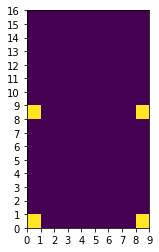

In [824]:
plt.pcolormesh(np.abs(np.imag(np.fft.rfftn(np.random.randn(16,16))))<1e-4, shading='flat')
plt.gca().set_aspect(1)
plt.xticks(np.arange(0,10,1));
plt.yticks(np.arange(0,17,1));

# Check commutation with differentiation

In [825]:
m = pyqg.QGModel()
mc = pyqg.QGModel(nx=8)

INFO:  Logger initialized
INFO:  Logger initialized


In [826]:
u = np.random.randn(2,64,64)
v = np.random.randn(2,64,64)

In [827]:
div_coarse_uv = op.fft_interpolate(m.ifft(m.ik*m.fft(u)+m.il*m.fft(v)), 64, 8)
uc = op.fft_interpolate(u,64,8)
vc = op.fft_interpolate(v,64,8)
coarse_div_uv = mc.ifft(mc.ik*mc.fft(uc)+mc.il*mc.fft(vc))

np.linalg.norm(div_coarse_uv-coarse_div_uv)

5.680185893437048e-20

In [828]:
div_coarse_uv = op.cut_off(m.ifft(m.ik*m.fft(u)+m.il*m.fft(v)), 8)
uc = op.cut_off(u,8)
vc = op.cut_off(v,8)
coarse_div_uv = mc.ifft(mc.ik*mc.fft(uc)+mc.il*mc.fft(vc))

np.linalg.norm(div_coarse_uv-coarse_div_uv)

5.680185893437048e-20

# Check that truncation does not affect low frequencies

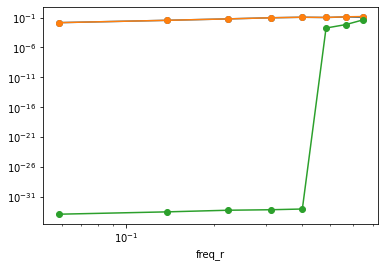

In [593]:
sp(op.fft_interpolate(u[0],64,32))
sp(op.fft_interpolate(u[0],64,32,truncate_2h=False))
sp(op.fft_interpolate(u[0],64,32)-op.fft_interpolate(u[0],64,32,truncate_2h=False))

# Check new subgrid forcing function

In [989]:
dss = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_512/[0-9].nc', concat_dim='run', combine='nested', decode_times=False)

In [990]:
q = dss.q.isel(time=-1,run=0).values

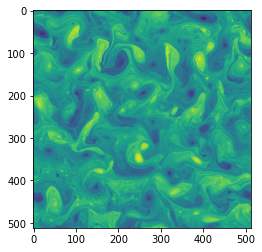

In [991]:
plt.imshow(q[0])

In [992]:
forcing_op1, m_op1, _ = op.PV_subgrid_forcing(q, 48, op.Operator1, EDDY_PARAMS)
forcing_op2, m_op2, _ = op.PV_subgrid_forcing(q, 48, op.Operator2, EDDY_PARAMS)
forcing_op5, m_op5, _ = op.PV_subgrid_forcing(q, 48, op.Operator5, EDDY_PARAMS)
forcing_32, m_32, _ = op.PV_subgrid_forcing(q, 48, op.Operator5, EDDY_PARAMS, '3/2-rule')

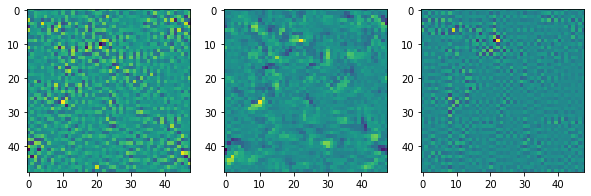

In [994]:
lev=1
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(forcing_op1[lev])
plt.subplot(1,3,2)
plt.imshow(forcing_op2[lev])
plt.subplot(1,3,3)
plt.imshow(forcing_32[lev])

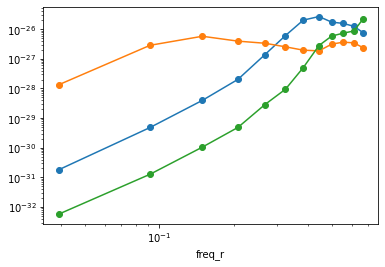

In [995]:
lev=1
sp(forcing_op1[lev])
sp(forcing_op2[lev])
sp(forcing_32[lev])

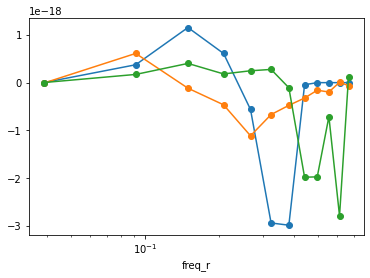

In [996]:
lev=0
csp(forcing_op1[lev], m_op1.q[lev])
csp(forcing_op2[lev], m_op2.q[lev])
csp(forcing_32[lev], m_32.q[lev])

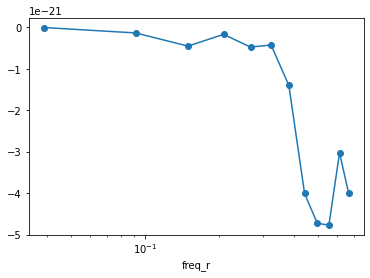

In [997]:
csp(forcing_32[1], m_32.q[1])

# Check that subgrid forcing + coarse advection = fine advection

In [110]:
dss = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-1].nc', concat_dim='run', combine='nested', decode_times=False)

In [111]:
q = dss.q.isel(time=-1,run=0).values

In [112]:
SGS, mf, m = op.PV_subgrid_forcing(q, 64, op.Operator5, EDDY_PARAMS,'3/2-rule')

In [113]:
advf = - op.advect(mf.q, mf.u, mf.v, dealias='3/2-rule') # minus to move to RHS
adv_pyqg = mf.ifft(mf._do_advection_anomaly_dealiasing())
adv_full = SGS + advf
adv = - op.cut_off(op.advect(m.q,m.u,m.v,dealias='3/2-rule'),64)

In [114]:
np.linalg.norm(adv-adv_full) / np.linalg.norm(adv)

1.5947931397163957e-17

In [115]:
np.linalg.norm(adv-(SGS+adv_pyqg)) / np.linalg.norm(adv)

7.004281586548919e-16

# Did you try to remove aliasing error from subgrid forcing?

In [998]:
dss = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_512/[0-9].nc', concat_dim='run', combine='nested', decode_times=False)

In [999]:
q = dss.q.isel(time=-1,run=0).values

In [1005]:
forcing_op1, m_op1, _ = op.PV_subgrid_forcing(q, 48, op.Operator1, EDDY_PARAMS)
forcing_op2, m_op2, _ = op.PV_subgrid_forcing(q, 48, op.Operator2, EDDY_PARAMS)

forcing_op1_alias, m_op1_alias, _ = op.PV_subgrid_forcing(q, 48, op.Operator1, EDDY_PARAMS, '3/2-rule')
forcing_op2_alias, m_op2_alias, _ = op.PV_subgrid_forcing(q, 48, op.Operator2, EDDY_PARAMS, '3/2-rule')

Text(0.5, 1.0, 'Sharp filter')

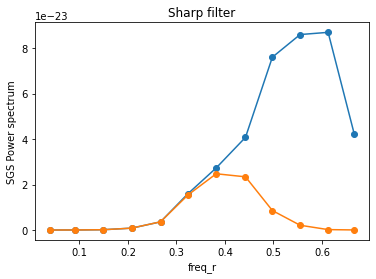

In [1010]:
sp(forcing_op1[0])
sp(forcing_op1_alias[0])
plt.xscale('linear')
plt.yscale('linear')
plt.ylabel('SGS Power spectrum')
plt.title('Sharp filter')

Text(0.5, 1.0, 'Gaussian filter')

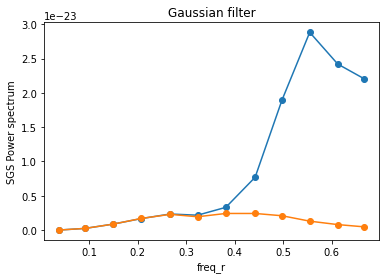

In [1012]:
sp(forcing_op2[0])
sp(forcing_op2_alias[0])
plt.xscale('linear')
plt.yscale('linear')
plt.ylabel('SGS Power spectrum')
plt.title('Gaussian filter')

# Implement 3/2-dealiasing to the pyqg model

In [101]:
q0 = np.random.randn(2,64,64)

In [102]:
m = pyqg.QGModel(); m.q = q0.copy(); m._invert()
m._do_advection()
dqdt = m.dqhdt.copy()

INFO:  Logger initialized


In [105]:
m = pyqg.QGModel(); m.q = q0.copy(); m._invert()
dqdt_new = m._do_background_flow() + m._do_advection_anomaly()
dqdt_alias = m._do_background_flow() + m._do_advection_anomaly_dealiasing()
#dqdt_new = m.dqhdt.copy()

INFO:  Logger initialized


In [106]:
np.linalg.norm(dqdt-dqdt_new) / np.linalg.norm(dqdt)

1.553551623589639e-16

In [107]:
np.linalg.norm(dqdt-dqdt_alias) / np.linalg.norm(dqdt)

0.577533559541685

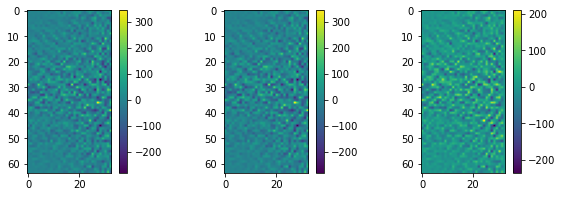

In [109]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(np.real(dqdt[0])); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.real(dqdt_new[0]));plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.real(dqdt_alias[0]));plt.colorbar()

In [118]:
m.wv2.shape

(256, 129)

# Test dealiased model

INFO:  Logger initialized


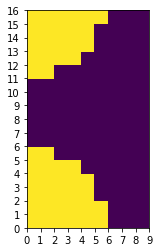

In [189]:
plt.pcolor(pyqg.QGModel(nx=16,filterfac=1e+20).filtr, shading='flat')
plt.gca().set_aspect(1)
plt.xticks(np.arange(10));
plt.yticks(np.arange(17));

INFO:  Logger initialized


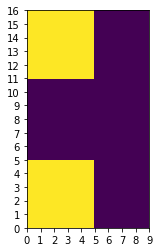

In [190]:
plt.pcolor(pyqg.QGModel(nx=16,dealiasing='2/3-rule').filtr, shading='flat')
plt.gca().set_aspect(1)
plt.xticks(np.arange(10));
plt.yticks(np.arange(17));

INFO:  Logger initialized


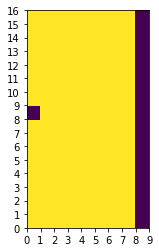

In [191]:
plt.pcolor(pyqg.QGModel(nx=16,dealiasing='3/2-rule').filtr, shading='flat')
plt.gca().set_aspect(1)
plt.xticks(np.arange(10));
plt.yticks(np.arange(17));

In [192]:
exp = run_simulation(EDDY_PARAMS._update({'tmax': 86400*360*20}))

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 1.16e-06, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 8.22e-06, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 6.64e-05, CFL: 0.047
INFO: Step: 4000, Time years:  1.9, KE: 4.17e-04, CFL: 0.161
INFO: Step: 5000, Time years:  2.3, KE: 4.81e-04, CFL: 0.200
INFO: Step: 6000, Time years:  2.8, KE: 5.12e-04, CFL: 0.180
INFO: Step: 7000, Time years:  3.2, KE: 4.69e-04, CFL: 0.174
INFO: Step: 8000, Time years:  3.7, KE: 5.09e-04, CFL: 0.180
INFO: Step: 9000, Time years:  4.2, KE: 4.83e-04, CFL: 0.171
INFO: Step: 10000, Time years:  4.6, KE: 4.78e-04, CFL: 0.170
INFO: Step: 11000, Time years:  5.1, KE: 4.46e-04, CFL: 0.160
INFO: Step: 12000, Time years:  5.6, KE: 4.48e-04, CFL: 0.209
INFO: Step: 13000, Time years:  6.0, KE: 4.21e-04, CFL: 0.184
INFO: Step: 14000, Time years:  6.5, KE: 4.56e-04, CFL: 0.155
INFO: Step: 15000, Time years:  6.9, KE: 4.89e-04, CFL: 0.207
INFO: Step: 16000, Time years:  7.4, KE: 5.30e-04, CF

Function 'run_simulation' executed in 52.2346s


In [193]:
two_thirds_lazy = run_simulation(EDDY_PARAMS._update({'filterfac': 1e+20, 'tmax': 86400*360*20}))

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 6.30e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 4.01e-06, CFL: 0.023
INFO: Step: 3000, Time years:  1.4, KE: 2.99e-05, CFL: 0.032
INFO: Step: 4000, Time years:  1.9, KE: 2.34e-04, CFL: 0.087
INFO: Step: 5000, Time years:  2.3, KE: 5.44e-04, CFL: 0.203
INFO: Step: 6000, Time years:  2.8, KE: 6.60e-04, CFL: 0.206
INFO: Step: 7000, Time years:  3.2, KE: 6.52e-04, CFL: 0.207
INFO: Step: 8000, Time years:  3.7, KE: 6.15e-04, CFL: 0.205
INFO: Step: 9000, Time years:  4.2, KE: 5.97e-04, CFL: 0.207
INFO: Step: 10000, Time years:  4.6, KE: 5.98e-04, CFL: 0.184
INFO: Step: 11000, Time years:  5.1, KE: 6.10e-04, CFL: 0.201
INFO: Step: 12000, Time years:  5.6, KE: 6.26e-04, CFL: 0.217
INFO: Step: 13000, Time years:  6.0, KE: 6.43e-04, CFL: 0.200
INFO: Step: 14000, Time years:  6.5, KE: 6.62e-04, CFL: 0.189
INFO: Step: 15000, Time years:  6.9, KE: 6.84e-04, CFL: 0.218
INFO: Step: 16000, Time years:  7.4, KE: 7.07e-04, CF

Function 'run_simulation' executed in 51.8784s


In [194]:
two_thirds = run_simulation(EDDY_PARAMS._update({'dealiasing': '2/3-rule', 'tmax': 86400*360*20}))

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 6.33e-07, CFL: 0.023
INFO: Step: 2000, Time years:  0.9, KE: 2.90e-06, CFL: 0.024
INFO: Step: 3000, Time years:  1.4, KE: 1.85e-05, CFL: 0.028
INFO: Step: 4000, Time years:  1.9, KE: 1.35e-04, CFL: 0.077
INFO: Step: 5000, Time years:  2.3, KE: 4.49e-04, CFL: 0.178
INFO: Step: 6000, Time years:  2.8, KE: 5.46e-04, CFL: 0.191
INFO: Step: 7000, Time years:  3.2, KE: 6.14e-04, CFL: 0.206
INFO: Step: 8000, Time years:  3.7, KE: 6.35e-04, CFL: 0.251
INFO: Step: 9000, Time years:  4.2, KE: 5.89e-04, CFL: 0.209
INFO: Step: 10000, Time years:  4.6, KE: 5.38e-04, CFL: 0.188
INFO: Step: 11000, Time years:  5.1, KE: 5.02e-04, CFL: 0.202
INFO: Step: 12000, Time years:  5.6, KE: 4.69e-04, CFL: 0.167
INFO: Step: 13000, Time years:  6.0, KE: 4.51e-04, CFL: 0.179
INFO: Step: 14000, Time years:  6.5, KE: 4.40e-04, CFL: 0.175
INFO: Step: 15000, Time years:  6.9, KE: 4.38e-04, CFL: 0.175
INFO: Step: 16000, Time years:  7.4, KE: 4.40e-04, CF

Function 'run_simulation' executed in 51.7473s


In [195]:
three_second_40 = run_simulation(EDDY_PARAMS._update({'dealiasing': '3/2-rule', 'nx': 40, 'tmax': 86400*360*20}))

INFO:  Logger initialized
INFO: Step: 1000, Time years:  0.5, KE: 6.14e-07, CFL: 0.015
INFO: Step: 2000, Time years:  0.9, KE: 2.97e-06, CFL: 0.015
INFO: Step: 3000, Time years:  1.4, KE: 2.01e-05, CFL: 0.018
INFO: Step: 4000, Time years:  1.9, KE: 1.60e-04, CFL: 0.047
INFO: Step: 5000, Time years:  2.3, KE: 5.93e-04, CFL: 0.108
INFO: Step: 6000, Time years:  2.8, KE: 7.48e-04, CFL: 0.128
INFO: Step: 7000, Time years:  3.2, KE: 7.28e-04, CFL: 0.127
INFO: Step: 8000, Time years:  3.7, KE: 6.75e-04, CFL: 0.131
INFO: Step: 9000, Time years:  4.2, KE: 6.05e-04, CFL: 0.117
INFO: Step: 10000, Time years:  4.6, KE: 5.60e-04, CFL: 0.120
INFO: Step: 11000, Time years:  5.1, KE: 5.33e-04, CFL: 0.115
INFO: Step: 12000, Time years:  5.6, KE: 5.19e-04, CFL: 0.105
INFO: Step: 13000, Time years:  6.0, KE: 5.13e-04, CFL: 0.116
INFO: Step: 14000, Time years:  6.5, KE: 5.14e-04, CFL: 0.116
INFO: Step: 15000, Time years:  6.9, KE: 5.20e-04, CFL: 0.127
INFO: Step: 16000, Time years:  7.4, KE: 5.38e-04, CF

Function 'run_simulation' executed in 76.9606s


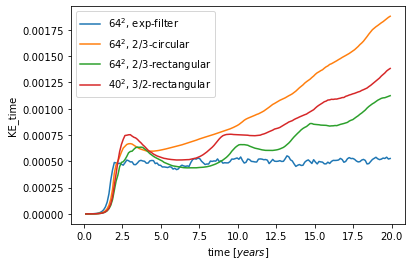

In [199]:
dataset_light_read(exp, averaging=False, truncate=False).KE_time.plot(label='$64^2$, exp-filter')
dataset_light_read(two_thirds_lazy, averaging=False, truncate=False).KE_time.plot(label='$64^2$, 2/3-circular')
dataset_light_read(two_thirds, averaging=False, truncate=False).KE_time.plot(label='$64^2$, 2/3-rectangular')
dataset_light_read(three_second_40, averaging=False, truncate=False).KE_time.plot(label='$40^2$, 3/2-rectangular')
plt.legend()

(0.0001, 1000.0)

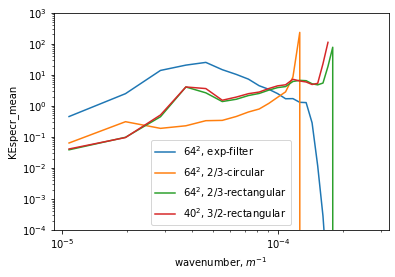

In [200]:
dataset_light_read(exp, averaging=False, truncate=False).KEspecr_mean.plot(label='$64^2$, exp-filter')
dataset_light_read(two_thirds_lazy, averaging=False, truncate=False).KEspecr_mean.plot(label='$64^2$, 2/3-circular')
dataset_light_read(two_thirds, averaging=False, truncate=False).KEspecr_mean.plot(label='$64^2$, 2/3-rectangular')
dataset_light_read(three_second_40, averaging=False, truncate=False).KEspecr_mean.plot(label='$40^2$, 3/2-rectangular')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-4,1e+3])

# Check subgrid forcing for 3/2-dealiasing

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
op5 = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator5-dealias-48/0.nc')
op1 = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/0.nc')

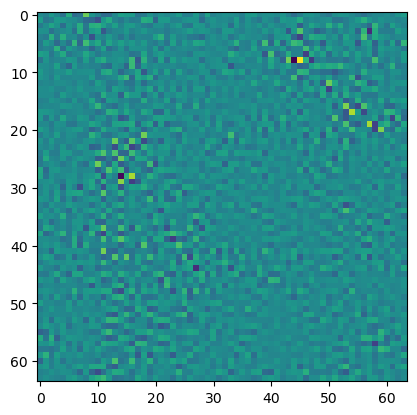

In [3]:
plt.imshow(op1.isel(time=-1, lev=0).q_forcing_advection)

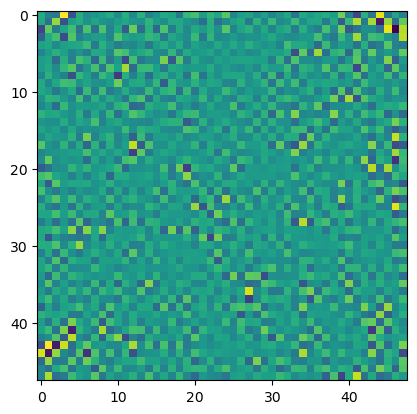

In [4]:
plt.imshow(op5.isel(time=-1, lev=0).q_forcing_advection)

/ext3/miniconda3/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/ext3/miniconda3/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


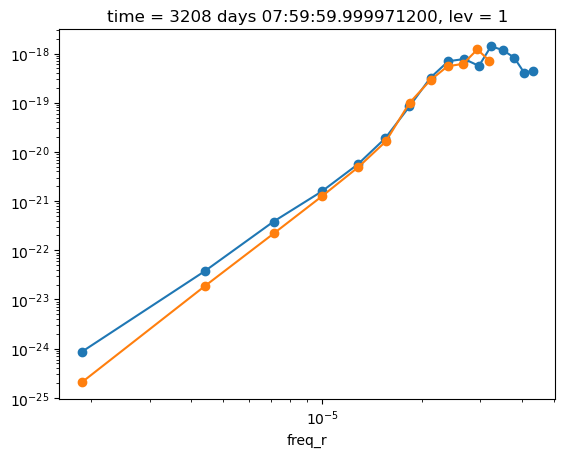

In [8]:
import xrft
sp(op1.isel(time=-10, lev=0).q_forcing_advection)
sp(op5.isel(time=-10, lev=0).q_forcing_advection)

/ext3/miniconda3/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/ext3/miniconda3/lib/python3.11/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


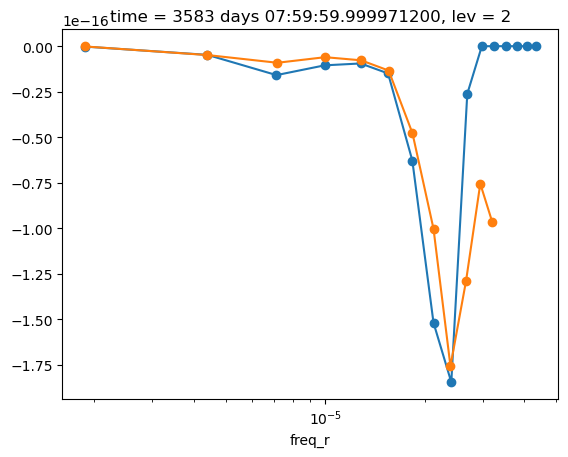

In [11]:
import numpy as np
idx = {'time': -1, 'lev': 1}
csp(op1.isel(**idx).q_forcing_advection, op1.isel(**idx).q)
csp(op5.isel(**idx).q_forcing_advection, op5.isel(**idx).q)

In [12]:
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator5-dealias-64/*.nc', combine='nested', concat_dim='run')